<a href="https://colab.research.google.com/github/fabricekfr/Backify/blob/master/Automl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! apt-get install default-jre
!java -version
! pip install h2o

In [7]:
import pandas as pd
import h2o
from h2o.automl import H2OAutoML

import matplotlib.pyplot as plt
from scipy import stats

%matplotlib inline

In [9]:
df = pd.read_csv('https://raw.githubusercontent.com/sagarmk/Forecasting-on-Air-pollution-with-RNN-LSTM/master/pollution.csv',index_col=0)

df.head()
print('number of rows = ', df.shape[0])

number of rows =  43800


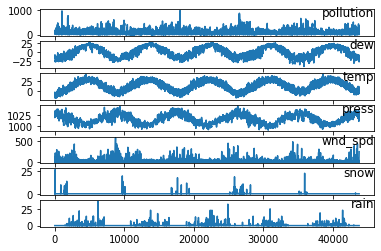

In [10]:
# specify columns to plot
values = df.values
groups = [0, 1, 2, 3, 5, 6, 7]
i = 1
# plot each column
plt.figure()
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group])
    plt.title(df.columns[group], y=0.5, loc='right')
    i += 1
plt.show()

In [11]:
df2 = df.copy()
num_lags = 3 # number of lags and window lenghts for mean aggregation
delay = 1 # predict target one step ahead
for column in df2:
    for lag in range(1,num_lags+1):
        df2[column + '_lag' + str(lag)] = df2[column].shift(lag*-1-(delay-1))
        if column != 'wnd_dir':
            df2[column + '_avg_window_length' + str(lag+1)] = df2[column].shift(-1-(delay-1)).rolling(window=lag+1,center=False).mean().shift(1-(lag+1))

df2.dropna(inplace=True) 

mask = (df2.columns.str.contains('pollution') | df2.columns.str.contains('lag') | df2.columns.str.contains('window'))
df_processed = df2[df2.columns[mask]]

# the columns in the processed dataframe
df_processed.columns

Index(['pollution', 'pollution_lag1', 'pollution_avg_window_length2',
       'pollution_lag2', 'pollution_avg_window_length3', 'pollution_lag3',
       'pollution_avg_window_length4', 'dew_lag1', 'dew_avg_window_length2',
       'dew_lag2', 'dew_avg_window_length3', 'dew_lag3',
       'dew_avg_window_length4', 'temp_lag1', 'temp_avg_window_length2',
       'temp_lag2', 'temp_avg_window_length3', 'temp_lag3',
       'temp_avg_window_length4', 'press_lag1', 'press_avg_window_length2',
       'press_lag2', 'press_avg_window_length3', 'press_lag3',
       'press_avg_window_length4', 'wnd_dir_lag1', 'wnd_dir_lag2',
       'wnd_dir_lag3', 'wnd_spd_lag1', 'wnd_spd_avg_window_length2',
       'wnd_spd_lag2', 'wnd_spd_avg_window_length3', 'wnd_spd_lag3',
       'wnd_spd_avg_window_length4', 'snow_lag1', 'snow_avg_window_length2',
       'snow_lag2', 'snow_avg_window_length3', 'snow_lag3',
       'snow_avg_window_length4', 'rain_lag1', 'rain_avg_window_length2',
       'rain_lag2', 'rain_avg_win

In [12]:
mask = df_processed.columns.str.contains('pollution')
df_processed[df_processed.columns[mask]].head(10)

,pollution,pollution_lag1,pollution_avg_window_length2,pollution_lag2,pollution_avg_window_length3,pollution_lag3,pollution_avg_window_length4
date,,,,,,,
2010-01-02 00:00:00,129.0,148.0,153.5,159.0,162.666667,181.0,156.50
2010-01-02 01:00:00,148.0,159.0,170.0,181.0,159.333333,138.0,146.75
2010-01-02 02:00:00,159.0,181.0,159.5,138.0,142.666667,109.0,133.25
2010-01-02 03:00:00,181.0,138.0,123.5,109.0,117.333333,105.0,119.00
2010-01-02 04:00:00,138.0,109.0,107.0,105.0,112.666667,124.0,114.50
2010-01-02 05:00:00,109.0,105.0,114.5,124.0,116.333333,120.0,120.25
2010-01-02 06:00:00,105.0,124.0,122.0,120.0,125.333333,132.0,129.00
2010-01-02 07:00:00,124.0,120.0,126.0,132.0,130.666667,140.0,136.00
2010-01-02 08:00:00,120.0,132.0,136.0,140.0,141.333333,152.0,143.00


In [14]:
df_processed.reset_index(drop=True,inplace=True)
df_train = df_processed.loc[:int(df_processed.shape[0]*0.8),:]
df_test = df_processed.loc[int(df_processed.shape[0]*0.8):,:]

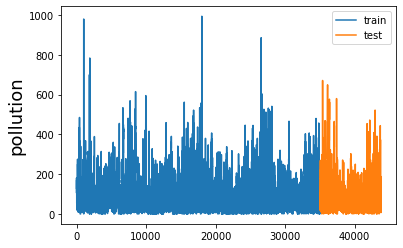

In [15]:
plt.plot(df_train.index,df_train['pollution'])
plt.plot(df_test.index,df_test['pollution'])
plt.ylabel('pollution',fontsize=18)
plt.legend(['train','test'])
plt.show()

In [16]:
h2o.init(nthreads=-1)

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.8" 2020-07-14; OpenJDK Runtime Environment (build 11.0.8+10-post-Ubuntu-0ubuntu118.04.1); OpenJDK 64-Bit Server VM (build 11.0.8+10-post-Ubuntu-0ubuntu118.04.1, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.6/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmps5tioqci
  JVM stdout: /tmp/tmps5tioqci/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmps5tioqci/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.1.3
H2O_cluster_version_age:,9 days
H2O_cluster_name:,H2O_from_python_unknownUser_m3z0cm
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.180 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"accepting new members, healthy"


In [19]:
!npm install -g localtunnel -qq > /dev/null
get_ipython().system_raw('lt --port 54321 >> url.txt 2>&1 &')
!cat url.txt

your url is: https://shy-shrimp-80.loca.lt


In [20]:
hf_train = h2o.H2OFrame(df_train)
hf_test = h2o.H2OFrame(df_test)
hf_train.describe()

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Rows:35037
Cols:46




,pollution,pollution_lag1,pollution_avg_window_length2,pollution_lag2,pollution_avg_window_length3,pollution_lag3,pollution_avg_window_length4,dew_lag1,dew_avg_window_length2,dew_lag2,dew_avg_window_length3,dew_lag3,dew_avg_window_length4,temp_lag1,temp_avg_window_length2,temp_lag2,temp_avg_window_length3,temp_lag3,temp_avg_window_length4,press_lag1,press_avg_window_length2,press_lag2,press_avg_window_length3,press_lag3,press_avg_window_length4,wnd_dir_lag1,wnd_dir_lag2,wnd_dir_lag3,wnd_spd_lag1,wnd_spd_avg_window_length2,wnd_spd_lag2,wnd_spd_avg_window_length3,wnd_spd_lag3,wnd_spd_avg_window_length4,snow_lag1,snow_avg_window_length2,snow_lag2,snow_avg_window_length3,snow_lag3,snow_avg_window_length4,rain_lag1,rain_avg_window_length2,rain_lag2,rain_avg_window_length3,rain_lag3,rain_avg_window_length4
type,int,int,real,int,real,int,real,int,real,int,real,int,real,int,real,int,real,int,real,real,real,real,real,real,real,enum,enum,enum,real,real,real,real,real,real,int,real,int,real,int,real,int,real,int,real,int,real
mins,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-33.0,-32.5,-33.0,-32.333333333333336,-33.0,-31.5,-19.0,-18.5,-19.0,-18.666666666666668,-19.0,-18.5,991.0,991.0,991.0,991.3333333333334,991.0,991.75,,,,0.45,0.6699999999998757,0.45,0.5966666666663781,0.45,0.6699999999987535,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,93.36549932928058,93.36247395610361,93.36064731569459,93.35882067528613,93.35874456526892,93.35493906441785,93.35667294574304,1.7743813682678187,1.774295744498676,1.7742101207295118,1.774181579473128,1.773953249422043,1.7740317378771024,12.154693609612686,12.154836315894626,12.154979022176542,12.154998049680815,12.15532151725317,12.15516454034306,1016.3997773781998,1016.3996917544328,1016.3996061306625,1016.3995966169106,1016.3994063418685,1016.3994919656368,,,,24.957655050375337,24.959479407483837,24.96130376459178,24.961363320680015,24.965131147073134,24.96329080686061,0.05748209036161772,0.05748209036161772,0.05748209036161772,0.057482090361617694,0.05748209036161772,0.0574749550475212,0.20989239946342433,0.2098923994634244,0.20989239946342433,0.20989239946342442,0.20989239946342433,0.20989239946342433
maxs,994.0,994.0,983.0,994.0,865.3333333333334,994.0,855.0,28.0,28.0,28.0,28.0,28.0,28.0,41.0,41.0,41.0,41.0,41.0,40.75,1046.0,1046.0,1046.0,1046.0,1046.0,1046.0,,,,585.6,583.5899999999997,585.6,581.58,585.6,579.5699999999994,27.0,26.5,27.0,26.0,27.0,25.5,36.0,35.5,36.0,35.0,36.0,34.5
sigma,91.91025864899358,91.91083022692456,90.816767204728,91.91120230473103,89.97156220224014,91.91130184370424,89.18544765954863,14.494245647416877,14.478716729023043,14.494479282813261,14.465956798069655,14.494785419767135,14.453505854826703,12.30718345069174,12.284682250601287,12.306924751796219,12.260385243735554,12.306614297205664,12.23209869901723,10.386615878686598,10.380773178783398,10.386605980920418,10.374856748136967,10.386584812040583,10.368012708638854,,,,51.31115782014467,50.661545347005465,51.314118858612034,50.15115419961667,51.3175242597527,49.67473886864784,0.7738710029485413,0.7544674396038666,0.7738710029485413,0.739272499343031,0.7738710029485413,0.7251850039981366,1.4899906873477353,1.4530405905633517,1.4899906873477353,1.4253262927082684,1.4899906873477353,1.4005950908345153
zeros,1946,1946,1766,1946,1680,1946,1616,636,344,636,240,636,178,882,518,882,376,882,285,0,0,0,0,0,0,,,,0,0,0,0,0,0,34706,34649,34706,34595,34706,34544,33521,33077,33521,32712,33521,32389
missing,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,129.0,148.0,153.5,159.0,162.66666666666666,181.0,156.5,-15.0,-13.0,-11.0,-11.0,-7.0,-10.0,-4.0,-4.5,-5.0,-4.666666666666667,-5.0,-4.75,1020.0,1020.5,1021.0,1021.0,1022.0,1021.25,SE,SE,SE,2.68,3.125,3.57,3.87,5.36,4.465,0.0,0.0,0.0,0.3333333333333333,1.0,0.75,0.0,0.0,0.0,0.0,0.0,0.0
1,148.0,159.0,170.0,181.0,159.33333333333334,138.0,146.75,-11.0,-9.0,-7.0,-8.333333333333334,-7.0,-8.0,-5.0,-5.0,-5.0,-5.0,-5.0,-5.25,1021.0,1021.5,1022.0,1021.6666666666666,

In [22]:
y = 'pollution'
X = hf_train.columns
X.remove(y)
X

['pollution_lag1',
 'pollution_avg_window_length2',
 'pollution_lag2',
 'pollution_avg_window_length3',
 'pollution_lag3',
 'pollution_avg_window_length4',
 'dew_lag1',
 'dew_avg_window_length2',
 'dew_lag2',
 'dew_avg_window_length3',
 'dew_lag3',
 'dew_avg_window_length4',
 'temp_lag1',
 'temp_avg_window_length2',
 'temp_lag2',
 'temp_avg_window_length3',
 'temp_lag3',
 'temp_avg_window_length4',
 'press_lag1',
 'press_avg_window_length2',
 'press_lag2',
 'press_avg_window_length3',
 'press_lag3',
 'press_avg_window_length4',
 'wnd_dir_lag1',
 'wnd_dir_lag2',
 'wnd_dir_lag3',
 'wnd_spd_lag1',
 'wnd_spd_avg_window_length2',
 'wnd_spd_lag2',
 'wnd_spd_avg_window_length3',
 'wnd_spd_lag3',
 'wnd_spd_avg_window_length4',
 'snow_lag1',
 'snow_avg_window_length2',
 'snow_lag2',
 'snow_avg_window_length3',
 'snow_lag3',
 'snow_avg_window_length4',
 'rain_lag1',
 'rain_avg_window_length2',
 'rain_lag2',
 'rain_avg_window_length3',
 'rain_lag3',
 'rain_avg_window_length4']

In [23]:
aml = H2OAutoML(max_runtime_secs = 600,
                seed = 42)
aml.train(x = X, 
          y = y,
          training_frame = hf_train,
          leaderboard_frame = hf_test)

AutoML progress: |████████████████████████████████████████████████████████| 100%


In [24]:
lb = aml.leaderboard

lb

model_id,mean_residual_deviance,rmse,mse,mae,rmsle
StackedEnsemble_AllModels_AutoML_20201007_224759,546.494,23.3772,546.494,12.3738,0.438331
StackedEnsemble_BestOfFamily_AutoML_20201007_224759,553.362,23.5236,553.362,12.5975,nan
XGBoost_grid__1_AutoML_20201007_224759_model_1,595.248,24.3977,595.248,13.1314,nan
XGBoost_grid__1_AutoML_20201007_224759_model_4,596.114,24.4155,596.114,13.0743,nan
GLM_1_AutoML_20201007_224759,598.125,24.4566,598.125,13.147,nan
XGBoost_grid__1_AutoML_20201007_224759_model_2,603.185,24.5598,603.185,13.2331,nan
XGBoost_3_AutoML_20201007_224759,614.109,24.7812,614.109,12.9004,0.450609
XGBoost_grid__1_AutoML_20201007_224759_model_5,625.415,25.0083,625.415,13.3926,nan
XGBoost_grid__1_AutoML_20201007_224759_model_3,636.812,25.2351,636.812,13.2164,nan
XGBoost_1_AutoML_20201007_224759,642.394,25.3455,642.394,13.6952,nan


In [26]:
leader_model = aml.leader
leader_model

Model Details
H2OStackedEnsembleEstimator :  Stacked Ensemble
Model Key:  StackedEnsemble_AllModels_AutoML_20201007_224759

No model summary for this model

ModelMetricsRegressionGLM: stackedensemble
** Reported on train data. **

MSE: 393.0499325121544
RMSE: 19.825486942623993
MAE: 10.827859972948382
RMSLE: NaN
R^2: 0.9541257727105785
Mean Residual Deviance: 393.0499325121544
Null degrees of freedom: 10065
Residual degrees of freedom: 10054
Null deviance: 86251690.69713998
Residual deviance: 3956440.620667346
AIC: 88725.71695530787

ModelMetricsRegressionGLM: stackedensemble
** Reported on cross-validation data. **

MSE: 701.028816051304
RMSE: 26.476948767773525
MAE: 13.329564351811891
RMSLE: NaN
R^2: 0.9170110463108992
Mean Residual Deviance: 701.028816051304
Null degrees of freedom: 35036
Residual degrees of freedom: 35026
Null deviance: 295997815.6157888
Residual deviance: 24561946.627989538
AIC: 329036.3578523868
